In [1]:
import sys
sys.path.append('..')

# Key Molecular Properties in Drug Design

Drug design is a process that needs to take into accounts multiple parameters. First, the molecule needs to be of course active, i.e. interact with its biological target to induce some therapeutic effect. Second, this molecule should also have a set of other desirable molecular properties that are known under the term ADMET (absorption, distribution, metabolism, excretion, and toxicity). These properties ensure that our compound will reach its target and will not induce any side effects.

## Activity

Biological activity of a compound is measured in a laboratory by conducting biological **assays** that tests how well our molecule binds and interacts with its biological target. An assay can be done using proteins or whole cells, and there are many types of activity measurements that can be done. For example, we can test only if the molecule binds to its target or look for a specific interaction that causes a desirable effect or inhibition. The activity values are usually expressed as:

- **EC$_{50}$**/**IC$_{50}$** - molecule concentration at which half of the effect or inhibition (blockage) is reached; the lower this value is, the stronger the effect induced by the molecule is.
- **Ki** - the inhibition constant, which measures the binding affinity; again, lower values correspond to stronger binding.
- **Inhibition in %** - the percentage of inhibited proteins.

Oftentimes, XC$_{50}$ and Ki values are converted to the negative logarithmic scale. This is denoted by the letter "*p*" in front of the activity type. This operation reduces the impact of extremely high values. After this transformation, higher values correspond to stronger activity.

For example, pIC$_{50}$ = $-\log_{10} $ IC$_{50}$.


## ADMET

There are myriads of chemical properties that can be measured to ensure the success of our molecule. Depending on the drug target, we might want to optimize different ADMET properties. If our drug needs to work in the central nervous system, we need to check the **blood-brain barrier permeability**. Other drugs that are administered orally need to **absorbed in the intestine**. Our molecule needs to be **metabolically stable**, which means it is not metabolized before it reaches its destination. On the other hand, we need to make sure it is finally metabolized and does not accumulate in the organism. Eventually, drugs can not be **toxic** or induce any serious side effects by interacting with other biological targets (**off-targets**). This is a difficult property to optimize as toxicity is a non-specific property - there are many possible interactions that can cause toxicity, e.g. **hERG inhibition** leads to severe cardiotoxicity (blocked potassium ion channels will cause heart failure).

# ChEMBL

[ChEMBL](https://www.ebi.ac.uk/chembl/) is a public database of bioactive compounds. The experimentally measured data points are gathered here and they can be used to train machine learning models. It should be noted that this database is manually curated, and the data is pulled from publications and patents. The quality of this data is not always perfect, and the same compound can have multiple drastically different activity values depending on the site the experiments were conducted in. Sometimes these values can contain errors, either caused by humans or incorrect parsing of source documents.

![assay](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a0/96_well_plate.jpg/1599px-96_well_plate.jpg)

Activity data extracted from ChEMBL can be used to train ML models. Because we use the structural information (fingerprints or molecular graphs), these models are also called **QSAR models**, where QSAR stands for Quantitative Structure-Activity Relationship.

**Exercise 1.** Choose one of the targets below and download activity data for this target from ChEMBL. Use one of the activity types (e.g. Ki or IC$_{50}$) to train an ML model. Split the data and print the results of evaluation on the testing set.

- MAO-B (monoamine oxidase B) - its inhibitors can be used to treat symptoms of Parkinson's disease
- ACE2 (angiotensin-converting enzyme 2) - serves as an entry point for SARS-CoV-2
- COX-2 (cyclooxygenase 2) - the taget of non-steroidal anti-inflammatory drugs
- 5-HT3 (serotonin receptor 3) - common target of antiemetics (drugs against vomiting nad nausea)
- hERG - potassium ion channel that is often connected to cardiotoxicity (when inhibited)

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem

In [79]:
herg = pd.read_csv('herg_chembl.csv', sep=';')
herg.head()

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type
0,CHEMBL597737,NaN,None,338.39,0,3.31,39,Fc1ccccc1-c1ccc2oc(N3CCN4CCC3CC4)nc2n1,IC50,'=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1159071,1,Scientific Literature,J Med Chem,2010.0,None,NaN,NaN
1,CHEMBL403181,NaN,None,512.68,2,5.63,20,CCc1noc2cc3c(cc12)CCN(CCCSc1nnc(-c2cccc4nc(C)c...,IC50,'=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1142271,1,Scientific Literature,Bioorg Med Chem Lett,2008.0,None,NaN,NaN
2,CHEMBL257946,NaN,None,498.66,1,5.37,18,Cc1ccc2c(-c3nnc(SCCCN4CCc5cc6onc(C)c6cc5CC4)n3...,IC50,'=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1142271,1,Scientific Literature,Bioorg Med Chem Lett,2008.0,None,NaN,NaN
3,CHEMBL550652,NaN,None,325.42,0,2.26,1c,Cn1cnnc1C1CCN(C(=O)NC2CC2c2ccccc2)CC1,IC50,'>',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1152451,1,Scientific Literature,J Med Chem,2009.0,None,NaN,NaN
4,CHEMBL552196,NaN,None,341.41,0,3.13,1f,Cc1c(O)noc1C1CCN(C(=O)NC2CC2c2ccccc2)CC1,IC50,'>',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1152451,1,Scientific Literature,J Med Chem,2009.0,None,NaN,NaN


In [80]:
herg['Standard Relation'].value_counts()

'='     9502
'>'     3623
'<'      251
'>='      15
'<='       4
'~'        1
Name: Standard Relation, dtype: int64

In [81]:
herg['Standard Units'].value_counts()

nM         13387
ug.mL-1       12
ucm            3
µM             1
Name: Standard Units, dtype: int64

In [82]:
herg = herg[herg['Standard Units'] == 'nM']
#herg = herg[herg['Standard Relation'] == '=']

In [85]:
herg['Standard Relation'] = herg['Standard Relation'].astype('category')

In [94]:
herg = herg[herg['Standard Relation'] == "'='"]
len(herg)

9492

In [97]:
herg['pIC50'] = -np.log10(herg['Standard Value'].astype(float) * 1e-9)

/tmp/ipykernel_51875/2999269586.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  herg['pIC50'] = -np.log10(herg['Standard Value'].astype(float) * 1e-9)


<Axes: >

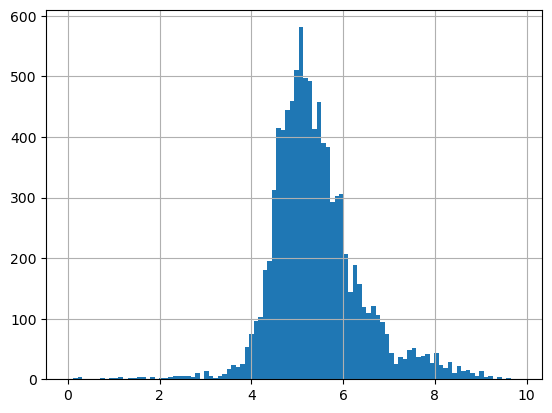

In [100]:
herg['pIC50'].hist(bins=100)

If you want to automate your data pipelines, you can use the ChEMBL Python API, as shown in the example below.

In [104]:
from chembl_webresource_client.new_client import new_client
from tqdm.notebook import tqdm

# target = new_client.target
# activity = new_client.activity
# bace = target.filter(pref_name__iexact='serotonin receptor 3').only('target_chembl_id')[0]
# activities_provider = activity.filter(target_chembl_id=bace['target_chembl_id']).filter(standard_type="IC50")
# activities = list(tqdm(activities_provider))
# df_bace = pd.DataFrame.from_records(activities)

In [105]:
# molecule = new_client.molecule
# compounds_provider = molecule.filter(
#     molecule_chembl_id__in=list(df_bace["molecule_chembl_id"])
# ).only("molecule_chembl_id", "molecule_structures")
# compounds = list(tqdm(compounds_provider))
# df_cmpds = pd.DataFrame.from_records(compounds)
# print(f"DataFrame shape: {df_cmpds.shape}")

In [110]:
from rdkit.Chem import rdMolDescriptors, Descriptors, Lipinski, Crippen
from rdkit.Chem.Fragments import fr_Al_OH, fr_COO, fr_Ar_OH, fr_imide, fr_nitro, fr_sulfonamd, fr_ester, fr_amide, fr_aldehyde, fr_epoxide, fr_halogen, fr_methoxy, fr_phenol, fr_ether, fr_NH1, fr_NH0, fr_NH2
import warnings
from rdkit.Chem import rdPartialCharges

class Featurizer:
    def __init__(self, y_column, smiles_col='Drug', **kwargs):
        self.y_column = y_column
        self.smiles_col = smiles_col
        self.__dict__.update(kwargs)

    def __call__(self, df):
        raise NotImplementedError()


class PropertyFeaturizer(Featurizer):
    def __init__(self, y_column='value', smiles_col='Smiles', **kwargs):
        super().__init__(y_column, smiles_col, **kwargs)
        self.property_name = self.__class__.__name__.replace('Featurizer', '')


    def __call__(self, df):
        features = []
        labels = []
        for i, row in df.iterrows():
            smiles = row[self.smiles_col]
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                warnings.warn(f'Could not parse {smiles} as SMILES')
                continue
            features.append(self._get_properties(mol))
            labels.append(row[self.y_column])
        return features, df[self.y_column].to_list()
    def _get_properties(self, mol):
        num_C = self.get_atom_count(mol, 'C')
        num_N = self.get_atom_count(mol, 'N')
        num_O = self.get_atom_count(mol, 'O')
        num_halogen = fr_halogen(mol)
        TPSA = rdMolDescriptors.CalcTPSA(mol)
        MW = Descriptors.MolWt(mol)
        HBA = Lipinski.NumHAcceptors(mol)
        HBD = Lipinski.NumHDonors(mol)
        FractionCSP3 = rdMolDescriptors.CalcFractionCSP3(mol)
        logP = Crippen.MolLogP(mol)
        graph_index = Chem.GraphDescriptors.BalabanJ(mol)
        num_rotatable_bonds = Lipinski.NumRotatableBonds(mol)
        mol_rf = Crippen.MolMR(mol)
        min_partial_charge, max_partial_charge = self._get_min_max_charges(mol)
        avg_heavy_atom_weight = Chem.Lipinski.HeavyAtomCount(mol)
        num_valence_electrons = Descriptors.NumValenceElectrons(mol)
        AP = self.aromatic_proportion(mol)
        bertzCT = Chem.GraphDescriptors.BertzCT(mol)
        HallKierAlpha = Chem.rdMolDescriptors.CalcHallKierAlpha(mol)
        maccs = rdMolDescriptors.GetMACCSKeysFingerprint(mol)
        maccs = np.array(maccs)

        return [num_C, num_N, num_O, num_halogen, TPSA, MW, HBA, HBD, FractionCSP3, graph_index, num_rotatable_bonds, mol_rf, avg_heavy_atom_weight, num_valence_electrons, logP, AP, min_partial_charge, max_partial_charge, bertzCT, HallKierAlpha] + maccs.tolist()
    def get_atom_count(self, mol, atom):
        count = mol.GetSubstructMatches(Chem.MolFromSmarts(f'[{atom}]'))
        return len(count)
    def _get_min_max_charges(self, mol):
        rdPartialCharges.ComputeGasteigerCharges(mol)
        charges = [atom.GetProp('_GasteigerCharge') for atom in mol.GetAtoms()]
        max_partial_charge = float(max(charges))
        min_partial_charge = float(min(charges))
        # if nan replace with 0
        if np.isnan(max_partial_charge) or np.isinf(max_partial_charge):
            max_partial_charge = 0
        if np.isnan(min_partial_charge) or np.isinf(min_partial_charge):
            min_partial_charge = 0
        return min_partial_charge, max_partial_charge
    def aromatic_proportion(self, mol):
        aromatic_atoms = [atom.GetIsAromatic() for atom in mol.GetAtoms()]
        all_heavy_atoms = len([atom for atom in mol.GetAtoms() if atom.GetAtomicNum() != 1])
        return sum(aromatic_atoms) / all_heavy_atoms


### IC50

In [111]:
# TODO: Use your training script
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(herg, random_state=42, train_size=0.8)

In [112]:
len(df_train), len(df_test)

(7593, 1899)

In [113]:
X_train, y_train = PropertyFeaturizer(y_column='Standard Value')(df_train)
X_test, y_test = PropertyFeaturizer(y_column='Standard Value')(df_test)

In [114]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
model = RandomForestRegressor()

In [115]:
model.fit(X_train, y_train)

RandomForestRegressor()

In [116]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
y_pred = model.predict(X_test)
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'R2: {r2_score(y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')

MSE: 328391926499764.44
R2: 0.10942211510291766
MAE: 1255868.7341723992


### pIC50

In [117]:
X_train, y_train = PropertyFeaturizer(y_column='pIC50')(df_train)
X_test, y_test = PropertyFeaturizer(y_column='pIC50')(df_test)

In [118]:
model_base_reg = RandomForestRegressor()
model_base_reg.fit(X_train, y_train)

RandomForestRegressor()

In [119]:
y_pred = model_base_reg.predict(X_test)
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'R2: {r2_score(y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')

MSE: 0.38802463805222975
R2: 0.6064422238863447
MAE: 0.42961573318662244


In [120]:
# from sklearn.model_selection import GridSearchCV
# param_grid = {
#     'n_estimators': [x for x in range(50, 500, 25)],
#     'max_depth': [3, 5, 7],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2'],
#     'random_state': [42]
# }

In [121]:
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
# grid_search.fit(X_train, y_train)

In [122]:
# y_pred = grid_search.predict(X_test)
# print(f'MSE: {mean_squared_error(y_test, y_pred)}')
# print(f'R2: {r2_score(y_test, y_pred)}')
# print(f'MAE: {mean_absolute_error(y_test, y_pred)}')

**(optional) Excercise 1.1.** *(advanced data splitting methods)* - skip

You might be surprised how good results you can achieve using a random data split. The model performance measured this way can be misleading as ChEMBL contains many similar compounds, series of compounds containing the same scaffold, or even duplicated records. Thus, a better form of evaluation would be to employ a more advanced splitting method, e.g. **scaffold-based split** in which all compounds containing the same scaffold are put in the same set. Another option is to use a **time-based split** because most records in ChEBML should be tagged with the date of their publication. 

Don't be discouraged by the lower results you obtain with these splits. By evaluating your model this way, you get more realistic scores that better reflect the future use cases of your model. The fact that lower evaluation scores may correspond to a better model is known as the **Kubinyi paradox**.

You can now implement a more advanced data split and compare the prediction results on the testing set.

In [123]:
# TODO repeat training with scaffold/time/clustering-based split

**(optional) Excercise 1.2.** *(label transformations)*

As mentioned above, using the logarithmic values can improve the prediction results by eliminating extreme values. Another option is to transform continuous measurements into binary classes, where active compounds are those with IC$_{50}$/Ki values below a certain treshold, and the rest is assumed inactive. This approach can also help dealing with inaccurate noisy measurements.

Try to convert labels into pIC$_{50}$/pKi values or change the regression task to a binary classification problem.

<Axes: >

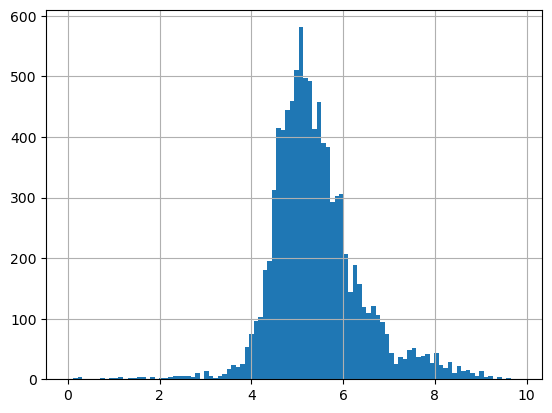

In [131]:
herg['pIC50'].hist(bins=100)

In [134]:
np.percentile(herg['pIC50'], 80)

6.036212172654444

In [135]:
activity_threshold = 6
herg['class'] = herg['pIC50'].apply(lambda x: 0 if x < activity_threshold else 1)

In [136]:
df_train, df_test = train_test_split(herg, random_state=42, train_size=0.8)

In [137]:
X_train, y_train = PropertyFeaturizer(y_column='class')(df_train)
X_test, y_test = PropertyFeaturizer(y_column='class')(df_test)

In [138]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
model = RandomForestClassifier()

In [139]:
model.fit(X_train, y_train)

RandomForestClassifier()

In [140]:
y_pred = model.predict_proba(X_test)[:, 1]
print(f'Accuracy: {accuracy_score(y_test, y_pred > 0.5)}')
print(f'F1: {f1_score(y_test, y_pred > 0.5)}')
print(f'ROC AUC: {roc_auc_score(y_test, y_pred)}')

Accuracy: 0.8694049499736703
F1: 0.6352941176470588
ROC AUC: 0.8862775744850693


**(optional) Excercise 1.3.** *(exploratory data analysis, data filtering)*

Can you find any discrepancies in the data? For example, do you find any outliers or duplicated SMILES strings? Can you solve these problems?

In [142]:
# Hint: A dot in the SMILES string indicates multiple compounds (this is a separator)
herg[herg.Smiles.str.contains('\.')]
# TODO: Perform Exploratory Data Analysis

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type,pIC50,class
16,CHEMBL1271816,NaN,None,460.07,0,3.64,15e,Cc1nc(C(=O)NCCCN2CCN(c3cccc(C)c3C)CC2)cc(C(C)(...,IC50,'=',...,CHEMBL1268978,1,Scientific Literature,Bioorg Med Chem Lett,2010.0,None,NaN,NaN,5.229148,0
17,CHEMBL1271756,NaN,None,486.88,0,4.16,15b,Cc1nc(C(=O)NCCCN2CCN(c3cccc(Cl)c3Cl)CC2)cc(C(C...,IC50,'=',...,CHEMBL1268978,1,Scientific Literature,Bioorg Med Chem Lett,2010.0,None,NaN,NaN,5.267606,0
35,CHEMBL240567,NaN,None,529.58,0,4.24,38h,O=C(c1cc(F)cc(F)c1)N1CCN(c2ccc(OC3CCN(C4CCCC4)...,IC50,'=',...,CHEMBL1138361,1,Scientific Literature,J Med Chem,2007.0,CHEMBL3307512,NaN,NaN,5.100000,0
37,CHEMBL239099,NaN,None,504.59,0,3.44,37e,N#Cc1ccc(C(=O)N2CCN(c3ccc(OC4CCN(C5CCC5)CC4)cc...,IC50,'=',...,CHEMBL1138361,1,Scientific Literature,J Med Chem,2007.0,CHEMBL3307512,NaN,NaN,5.030000,0
78,CHEMBL536480,NaN,None,474.45,0,2.90,E4031,Cc1cccc(CCN2CCC(C(=O)c3ccc(NS(C)(=O)=O)cc3)CC2...,IC50,'=',...,CHEMBL1137783,1,Scientific Literature,J Med Chem,2009.0,None,NaN,NaN,7.742321,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14860,CHEMBL5201061,NaN,None,584.88,0,2.20,31,COc1cc(OC)c(F)c(COc2cnc(Nc3cnn(CCN4CCNCC4)c3)n...,IC50,'=',...,CHEMBL5120772,1,Scientific Literature,Bioorg Med Chem,2022.0,None,NaN,BLOCKER,4.050610,0
14962,CHEMBL4757503,NaN,None,494.08,1,5.99,6i,CN1CCCC1CCOc1ccc(/C(=C(/CCCO)c2ccccc2)c2ccc(O)...,IC50,'=',...,CHEMBL4680094,1,Scientific Literature,J Med Chem,2016.0,None,TIME = 4.0 hr,INHIBITOR,5.267606,0
15010,CHEMBL5197909,NaN,None,612.94,1,2.97,29,COc1cc(OC)c(F)c(COc2cnc(Nc3cnn(CCNC4CCN(C)CC4)...,IC50,'=',...,CHEMBL5120772,1,Scientific Literature,Bioorg Med Chem,2022.0,None,NaN,BLOCKER,4.080922,0
15097,CHEMBL4879307,NaN,None,400.46,0,3.27,7c,CN(C)c1ccc(/N=N/c2ccccn2)c(O)c1.O=S(=O)(O)c1cc...,IC50,'=',...,CHEMBL4823327,1,Scientific Literature,ACS Med Chem Lett,2021.0,None,TIME = 48.0 hr,INHIBITOR,6.677781,1


# ZINC

[ZINC](https://zinc.docking.org/) is a database of commercially available compounds. This data can be used for **virtual screening**, i.e. finding active molecules using only *in silico* (computer) methods. These compounds can be then purchased and tested *in vitro* (in cells or biomolecules) or *in vivo* (in living organisms).

**Exercise 2.** Perform virtual screening. Use the model trained in Exercise 1 to find the most active compounds in a ZINC subset. Which compounds should be selected to be purchased or synthesized?

Save the output as a CSV file containing 100 compounds (SMILES strings) and their predicted activity values.

In [144]:
# TODO: inference: (1) load data (2) convert representation (3) predict activity (4) show drug candidates
from tqdm.notebook import tqdm
zinc_df = pd.read_csv('zinc.smi', sep=' ', chunksize=1000, names=['Smiles', 'id'], header=1)
for chunk in tqdm(zinc_df):
    X_zinc, _ = PropertyFeaturizer(y_column='id')(chunk)
    y_zinc = model_base_reg.predict(X_zinc)
    print(f'Chunk mean: {y_zinc.mean()}')
    print(f'Chunk best: {y_zinc.max()}')
    chunk['activity'] = y_zinc
    chunk.to_csv('zinc_activity.csv', mode='a', header=False)

0it [00:00, ?it/s]

Chunk mean: 4.146662993940015
Chunk best: 5.064642140907265
Chunk mean: 4.145378245164151
Chunk best: 5.021695244837727
Chunk mean: 4.161998424740907
Chunk best: 5.110685433184836
Chunk mean: 4.146230251666008
Chunk best: 4.931610001610435
Chunk mean: 4.148191831784017
Chunk best: 5.779600946445455
Chunk mean: 4.150173154375736
Chunk best: 5.197826079788704
Chunk mean: 4.180949421895509
Chunk best: 5.450409586032188
Chunk mean: 4.169646827828653
Chunk best: 5.126871196027546
Chunk mean: 4.163768722420084
Chunk best: 5.1748021551252394
Chunk mean: 4.16504606360995
Chunk best: 5.155836771871891
Chunk mean: 4.160130238961963
Chunk best: 5.208279915521455
Chunk mean: 4.168724696566367
Chunk best: 5.398530539099749
Chunk mean: 4.155865564534113
Chunk best: 5.45274610613606
Chunk mean: 4.152267266265884
Chunk best: 5.107712731643524
Chunk mean: 4.166824799961819
Chunk best: 5.140030666037131
Chunk mean: 4.172097184759206
Chunk best: 5.281195338026461
Chunk mean: 4.159811316151952
Chunk best:

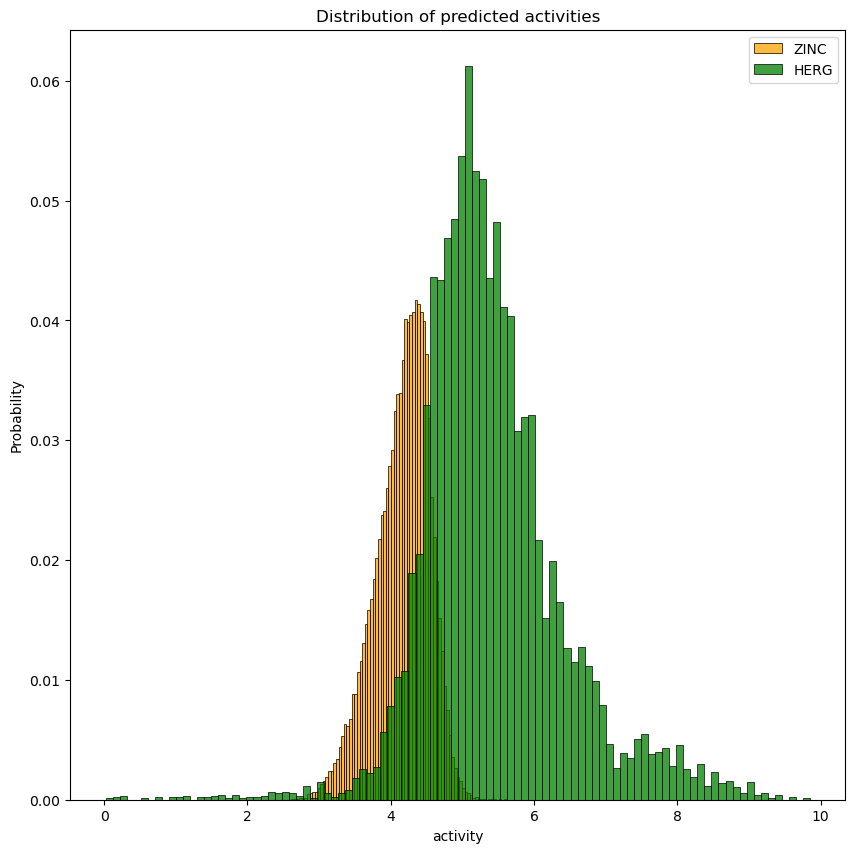

In [151]:
import seaborn as sns
zinc_activity_df = pd.read_csv('zinc_activity.csv', names=['Smiles', 'id', 'activity'])
fig, ax = plt.subplots(figsize=(10, 10))
sns.histplot(data=zinc_activity_df, x='activity', bins=100, ax=ax, stat='probability', color='orange')
sns.histplot(data=herg, x='pIC50', bins=100, ax=ax, stat='probability', color='green')

plt.title('Distribution of predicted activities')
plt.legend(['ZINC', 'HERG'])
plt.show()

In [156]:
zinc_activity_df.sort_values(by='activity', ascending=False).to_csv('zinc_activity_top100.csv', index=False)

**(optional) Exercise 2.1.** *(Compound novelty and diversity)*

How similar are the selected compounds to the training data? Can you measure the diversity of these compounds? How should these values impact your selection?

In [ ]:
# TODO: Check structural similarity

You can use **t-SNE** to find structural similarities in your dataset. t-SNE is a tool for high-dimensional data visualization (**dimensionality reduction**). It transforms n-dimensional data into 2-dimensional map in which distances should be proportional to the distances in the original space.

In [152]:
from sklearn.manifold import TSNE

def get_morgan(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=4)
    return np.array(fingerprint)

df_zinc = pd.read_csv('zinc.smi', sep=' ', index_col=1).sample(n=1000)
df_zinc['fingerprint'] = [get_morgan(smiles) for smiles in df_zinc.smiles]

In [153]:
tsne = TSNE(metric='jaccard')
components = tsne.fit_transform(np.stack(df_zinc.fingerprint))

/home/anton/miniconda3/envs/mldd23/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


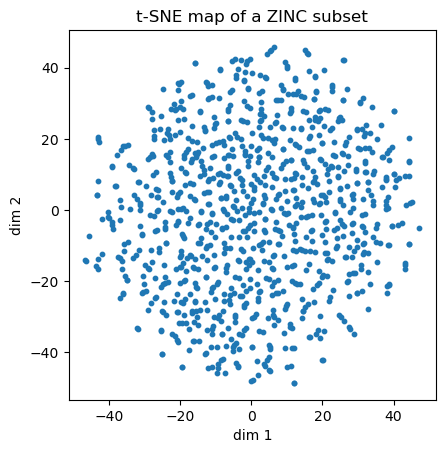

In [154]:
plt.scatter(components[:, 0], components[:, 1], s=10)
plt.gca().set_aspect('equal')
plt.title('t-SNE map of a ZINC subset')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.show()

**(optional) Exercise 2.2.** *(Additional ADMET filters)*

When selecting compounds, we need to consider also other properties, e.g. toxicity. Some structural patterns are well known to cause issues in terms of toxicity or synthesizability. We can quickly filter out compounds containing these patterns using their SMARTS strings ("regular expressions" for SMILES).

Use [SureChEMBL](https://www.surechembl.org/search/) to remove problematic compounds.

In [ ]:
# TODO: Use SMARTS to filter out compounds

# PubChem

[PubChem](https://pubchem.ncbi.nlm.nih.gov/) is a database of chemical information about small molecules. It contains various ADMET properties and 3D crystal structures of these molecules. You can easily find any compound using the SMILES representation or by drawing the structure in the tool on the website.

**(optional) Exercise 3.** What information can you find about your selected top compounds?